# Imports

In [1]:
import pandas as pd
from collections import Counter
from datetime import datetime
from sklearn.cluster import DBSCAN

In [2]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams["figure.figsize"] = (20, 10)

# Load the data

In [3]:
df = pd.read_csv(
    "data/technical_test_data.csv",
    names=[
        "user_id",
        "timestamp",
        "latitude",
        "longitude",
        "horizontal_precision",
        "speed",
        "crc32_hash"
    ]
)

# Enrich the data

In [4]:
df["datetime"] = df.timestamp.apply(pd.Timestamp.fromtimestamp)
df["date"] = df["datetime"].dt.date
df["weekday"] = df["datetime"].dt.weekday
df["dayofyear"] = df["datetime"].dt.dayofyear
df["speed_kmh"] = df["speed"]*3600/1000

In [5]:
min_date = df["date"].min()
dt = datetime(
        year=min_date.year,
        month=min_date.month,
        day=min_date.day
     )
min_timestamp = int(dt.timestamp())

In [6]:
df["timestamp_norm"] = df["timestamp"] - min_timestamp

In [7]:
df.head(5)

,user_id,timestamp,latitude,longitude,horizontal_precision,speed,crc32_hash,datetime,date,weekday,dayofyear,speed_kmh,timestamp_norm
0,861100071,1578873724,48.883953,2.331347,65.0,-1.0,477154077,2020-01-13 01:02:04,2020-01-13,0,13,-3.6,3724
1,861100071,1578873726,48.883941,2.331342,65.0,-1.0,477154077,2020-01-13 01:02:06,2020-01-13,0,13,-3.6,3726
2,861100071,1578873825,48.883954,2.331337,65.0,-1.0,477154077,2020-01-13 01:03:45,2020-01-13,0,13,-3.6,3825
3,861100071,1578873826,48.883941,2.331362,65.0,-1.0,477154077,2020-01-13 01:03:46,2020-01-13,0,13,-3.6,3826
4,861100071,1578873827,48.883941,2.331362,65.0,-1.0,477154077,2020-01-13 01:03:47,2020-01-13,0,13,-3.6,3827


# Data Filtering

In [8]:
df.horizontal_precision.value_counts().head(20)

65.00      32274
1000.00      841
120.00       516
28.49        275
170.00       222
165.00       221
107.00       153
200.00       151
488.00       110
153.00        59
128.00        58
147.00        57
138.00        55
133.00        50
350.00        50
171.00        45
2000.00       40
626.00        33
4000.00       31
201.00        28
Name: horizontal_precision, dtype: int64

In [9]:
df.query('speed_kmh < 5').shape

(84435, 13)

In [10]:
df.query('horizontal_precision < 66').shape

(87264, 13)

We will remove events where the speed is to high or the precision too low. For the current use case these are useless data.

In [11]:
df = df.query('speed_kmh < 5 & horizontal_precision < 66')

# Data Analysis

## Temporal data

Checking the event frequency of each day of the week

In [12]:
df.weekday.value_counts()

3    14177
2    13525
1    12565
4    11312
0    11011
5     7795
6     6278
Name: weekday, dtype: int64

Checking the stats on the number of event and their time range

In [13]:
df.groupby('user_id').agg(
    event_count=("user_id", "count"),
    min_timestamp=("timestamp", "min"),
    max_timestamp=("timestamp", "max")
)

,event_count,min_timestamp,max_timestamp
user_id,,,
861100071,35901,1578873724,1580083190
1853210804,24882,1578873868,1580081389
3330315587,15880,1578874245,1580083179


Let's observe the frequecy of the event over the time. We clearly see the day/night pattern for each member.

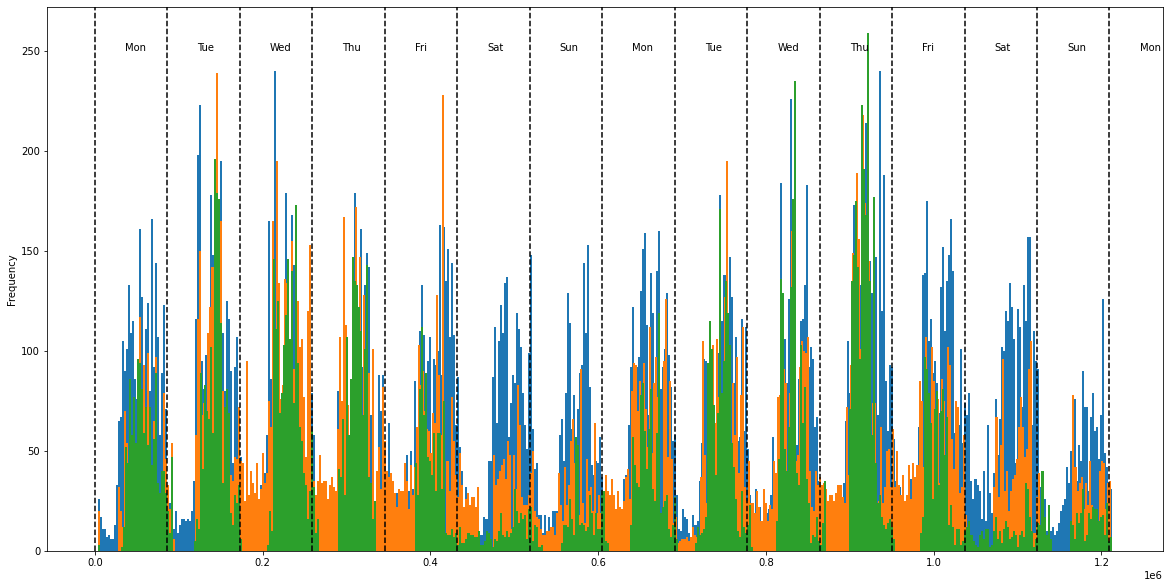

In [14]:
for i in df.user_id.unique():
    df.query('user_id == {}'.format(i)).timestamp_norm.plot.hist(bins=500)

DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(0, df.timestamp_norm.max(), 3600 * 24):
    plt.axvline(i, color='k', linestyle='--')
    plt.text(i + (3600*10), 250, DAYS[int((i/24/3600) % 7)])

## Geospatial data

Let's look at all the points all together

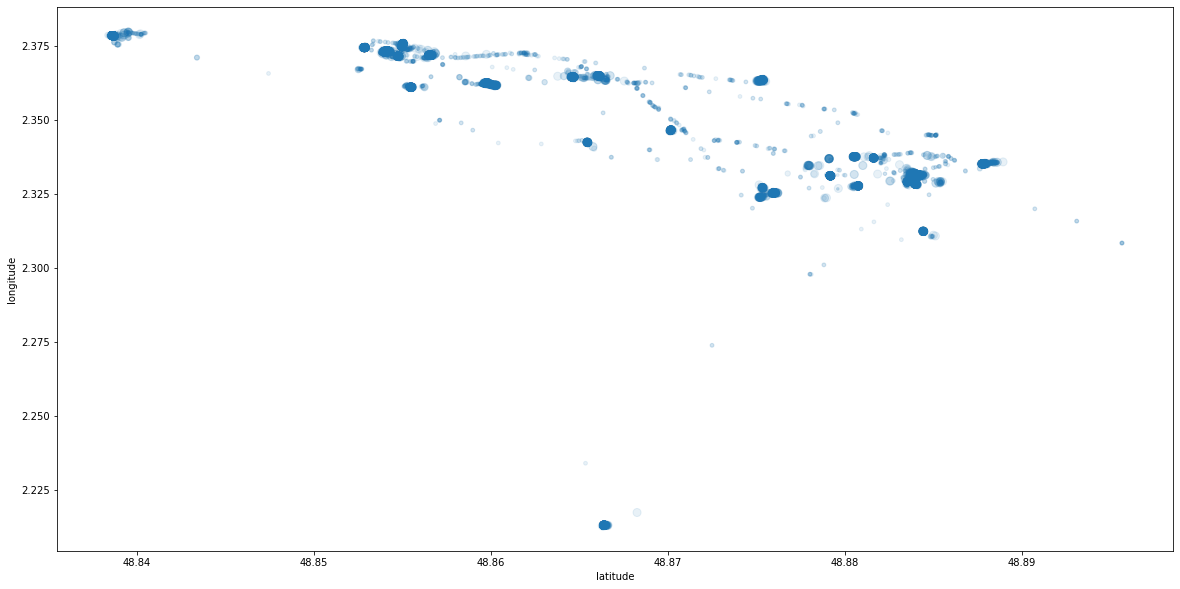

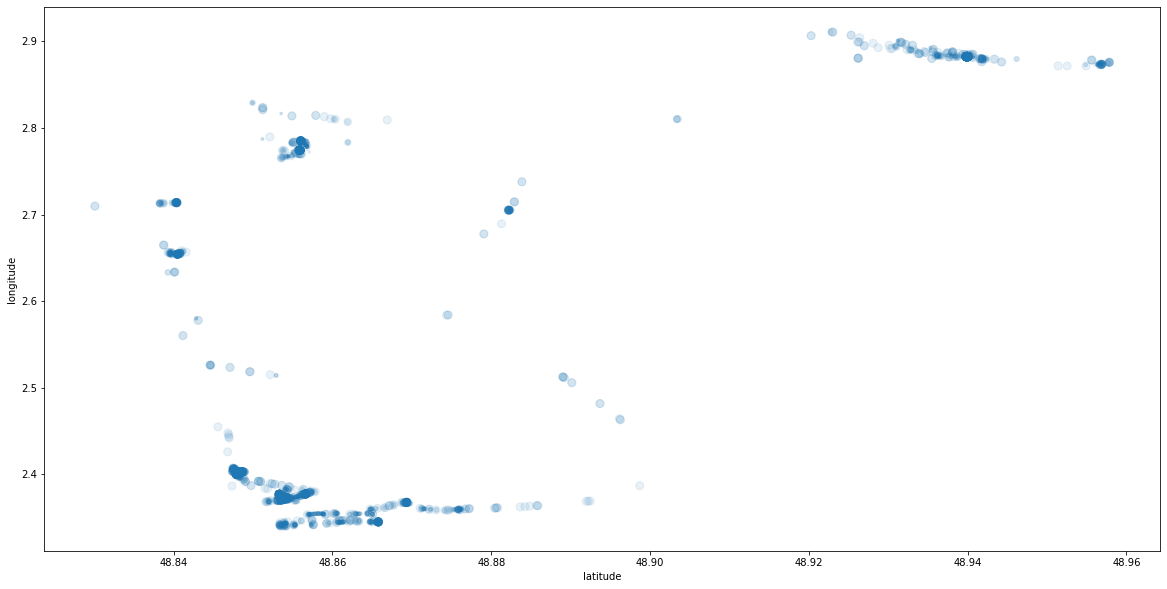

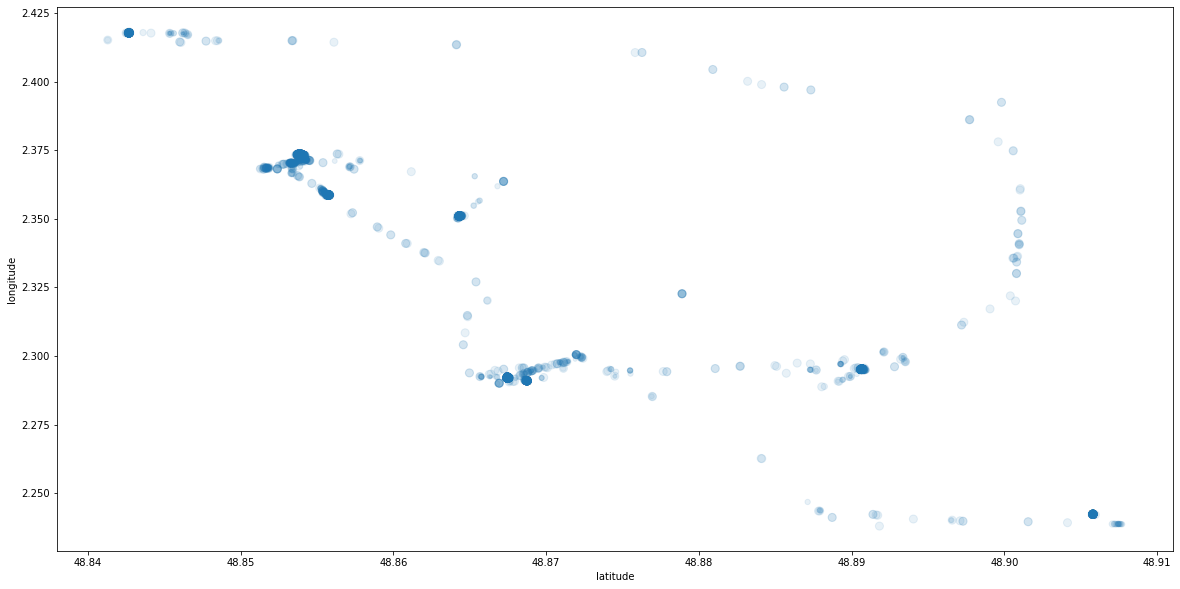

In [15]:
for i in df.user_id.unique():
    df.query('user_id == {}'.format(i)).plot.scatter(
        x="latitude",
        y="longitude",
        s="horizontal_precision",
        alpha=0.1
    )

Let's take the user `1853210804` and try to find its home and work places.

In [16]:
df_861100071 = df.query('user_id == 1853210804')

By changing the colors each day we tried to observe some pattern, but the result is not obvious.

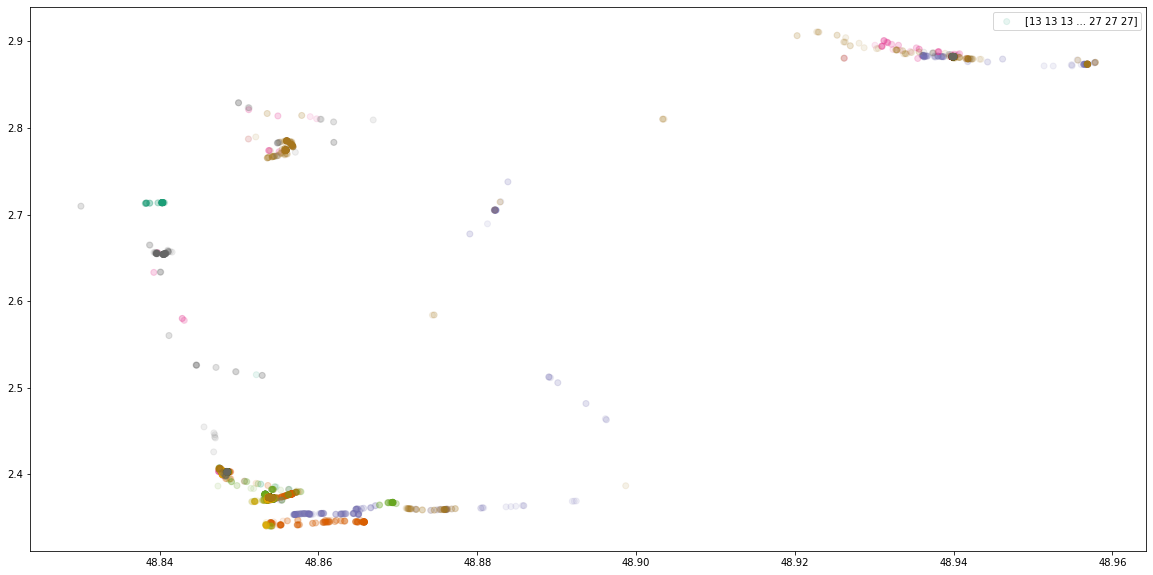

In [17]:
import matplotlib.pylab as plt

x = df_861100071.latitude.values
y = df_861100071.longitude.values
c = df_861100071.dayofyear.values

fig, ax = plt.subplots()
ax.scatter(
    x,
    y,
    c=c,
    alpha=0.1,
    label=c,
    cmap=plt.get_cmap("Dark2")
)
ax.legend()
plt.show()

Let's cluster the data to find point of interest. We use DBSCAN as it does not needs a number of clusters, uses proximity propagation as main mechanism and can exclude dots from its clustering.

The proximoty value `eps` used with the distance metric `haversine` (for geospatial data), can be set very easily by interpreting it as the actual distance in kilometers.

Here we want groups to have at least 100 points close to each other for at least 10 meters.

In [18]:
from math import radians, cos, sin, asin, sqrt


def haversine(X, Y):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lat1, lon1 = X
    lat2, lon2 = Y

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    return c * r

def haversine_acc(X, Y):

    lat1, lon1, ac1 = X
    lat2, lon2, ac2 = Y

    ac1 = ac1 * 0.001
    ac2 = ac2 * 0.001

    distance = haversine((lat1, lon1), (lat2, lon2))

    min_distance = max(0, distance - ac2 - ac1)
    max_distance = distance + ac1 + ac2

    return (max_distance + min_distance) / 2
    
    
if False:
    # Using haversine_acc did not bring better results
    db = DBSCAN(
        eps=0.05,
        min_samples=10,
        algorithm='ball_tree',
        n_jobs=-1,
        metric=lambda X, Y: haversine_acc(X, Y)
    )
    db.fit(
        df_861100071[['latitude', 'longitude', 'horizontal_precision']]
    )

if True:
    db = DBSCAN(
        eps=0.01,
        min_samples=100,
        algorithm='ball_tree',
        n_jobs=-1,
        metric=lambda X, Y: haversine(X, Y)
    )
    db.fit(
        df_861100071[['latitude', 'longitude']]
    )

Let's plot the detected points of interest

/tmp/ipykernel_4172944/927498452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_861100071['label'] = db.labels_


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

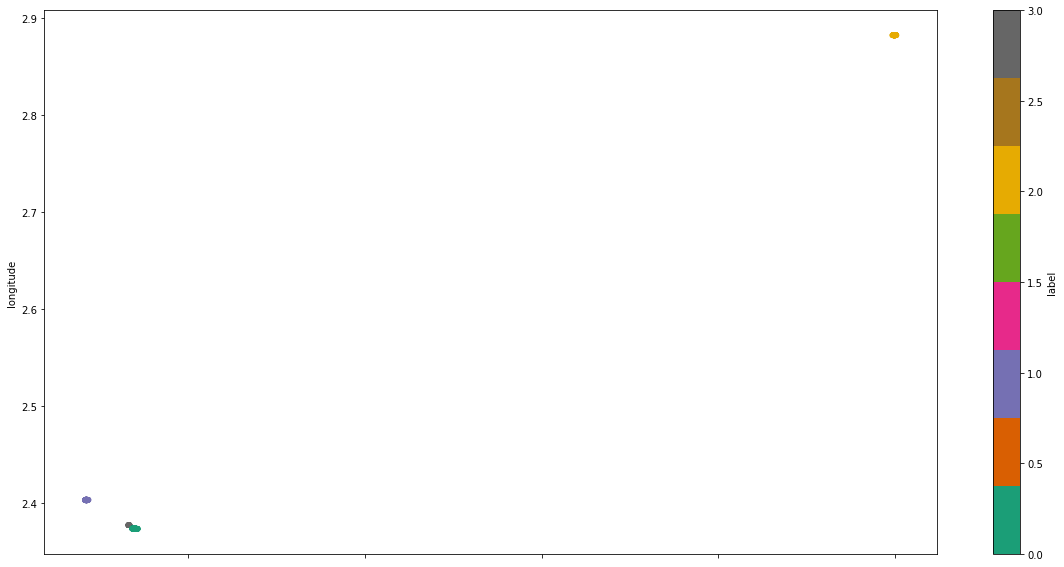

In [19]:
df_861100071['label'] = db.labels_
df_861100071.query("label >= 0").plot.scatter(
    x="latitude",
    y="longitude",
#    s="horizontal_precision",
    c="label",
    cmap=plt.get_cmap("Dark2"))

In [20]:
df_861100071.query("label >= 0").shape

(22481, 14)

4 points of interest were found

In [21]:
set(db.labels_)

{-1, 0, 1, 2, 3}

In [22]:
point_of_interest = (df_861100071.query("label >= 0")
             .groupby('dayofyear')
             .label
             .apply(Counter)
             .unstack()
)
print(point_of_interest.sum(axis=0).sort_values(ascending=False))
top_two_classes = (point_of_interest.sum(axis=0)
                                    .sort_values(ascending=False)
                                    .iloc[:2]
                                    .index
                                    .values)

0    13677.0
1     5599.0
2     3101.0
3      104.0
dtype: float64


In [23]:
point_of_interest.sum(axis=0)

0    13677.0
1     5599.0
2     3101.0
3      104.0
dtype: float64

In [24]:
WEEK_DAYS = [13, 14, 15, 16, 17, 20, 21, 22, 23, 24]
WEEK_END_DAYS = [18, 19, 25, 26]

top_two_class_events = point_of_interest[top_two_classes]
work_class = top_two_class_events.loc[WEEK_DAYS].sum(axis=0).idxmax()
home_class = top_two_class_events.loc[WEEK_END_DAYS].sum(axis=0).idxmax()

In [25]:
work_location = df_861100071.query("label == {}".format(work_class))[['latitude', 'longitude']].mean()
home_location = df_861100071.query("label == {}".format(home_class))[['latitude', 'longitude']].mean()

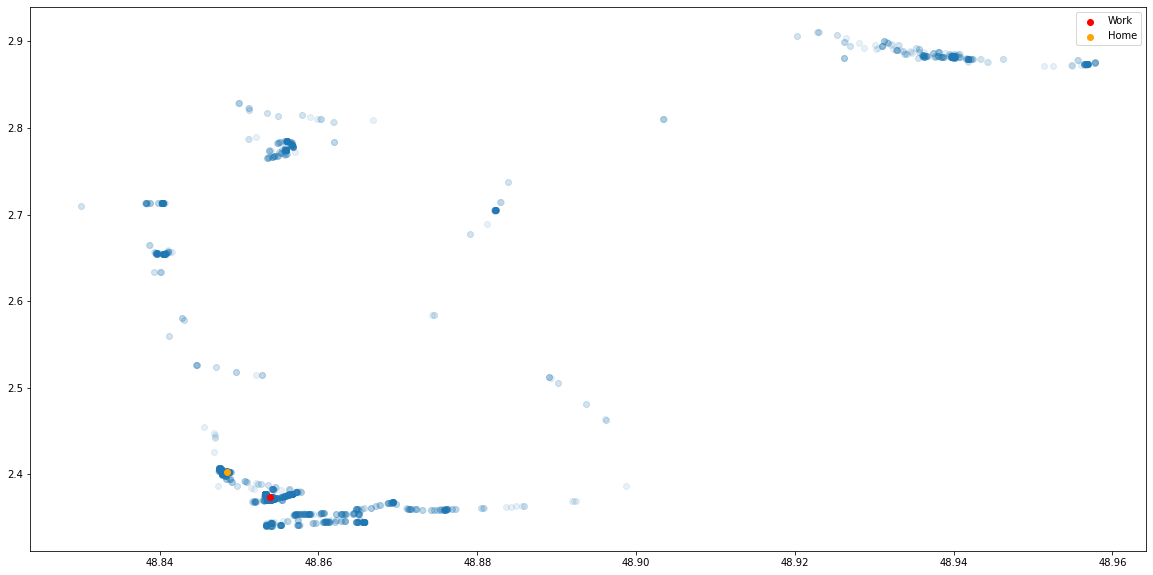

In [26]:
x = df_861100071.latitude.values
y = df_861100071.longitude.values
c = df_861100071.dayofyear.values
l = df_861100071.label.values
    
fig, ax = plt.subplots()

ax.scatter(
    x,
    y,
    alpha=0.1,
)
ax.scatter(
    x=work_location['latitude'],
    y=work_location['longitude'],
    c="red",
    label="Work",
    alpha=1,
)
ax.scatter(
    x=home_location['latitude'],
    y=home_location['longitude'],
    c="orange",
    label="Home",
    alpha=1,
)
ax.legend()
plt.show()